In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [5]:
import os, codecs, string, random

In [25]:
PATH = 'data/all_scripts.txt'

season = ''
episode = ''
scene = ''
data=[]

with open(PATH) as f:
    for line in f.readlines():
        line = line[:-1]
        if line[:3] == '>> ':
            episode = line[3:]
            season = int(line[10:12])
            continue
        if line[:2] == '> ':
            scene = line[2:]
            continue
        character, line = line.split(': ', 1)
        data.append([season, episode, scene, character, line])

bigbang_df = pd.DataFrame(data, columns = ['season', 'episode', 'scene', 'character', 'line'])

In [30]:
bigbang_df.groupby(['season','episode','scene']).count().reset_index(drop=False).groupby('season').count()[['scene']]

,scene
season,
1,157
2,205
3,193
4,219
5,198
6,211
7,207
8,191
9,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [37]:
recurrent_df = pd.DataFrame(bigbang_df.value_counts('character') > 90)

In [41]:
recurrent_df = recurrent_df[recurrent_df[0]==True].drop('Man')

In [45]:
recurrent_list = list(recurrent_df.index)

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [47]:
from helpers.helper_functions import simple_tokeniser, EXCLUDE_CHARS

In [56]:
def clean(line):
    for i in EXCLUDE_CHARS:
        line = line.replace(i, ' ')
    return line.lower()

In [58]:
bigbang_df['line'] = bigbang_df['line'].apply(clean)

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [60]:
bigbang_df['line_token'] = bigbang_df['line'].apply(simple_tokeniser)

In [156]:
all_lines = ''
for i in bigbang_df['line']:
    all_lines += i+ ' '

In [157]:
from collections import Counter

In [159]:
all_words_set = set(simple_tokeniser(all_lines))

In [84]:
corpus_count = pd.DataFrame(Counter(simple_tokeniser(all_lines)).most_common(), columns=['word', 'count'])

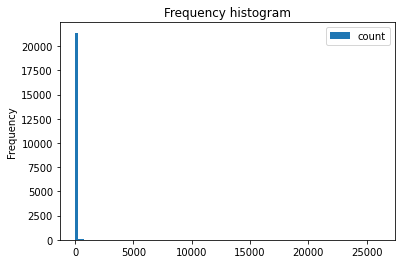

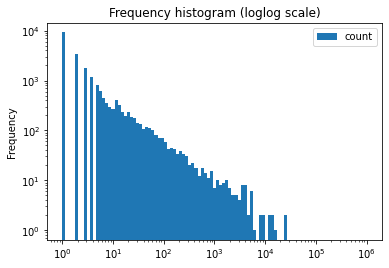

In [86]:
corpus_count.plot.hist(by="count", bins=100, title="Frequency histogram")
corpus_count.plot.hist(by="count", loglog=True, bins=np.logspace(0, 6, 100),
                           title="Frequency histogram (loglog scale)");

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [88]:
bigbang_df['words'] = bigbang_df['line_token'].apply(len)

In [94]:
bigbang_df.groupby('character')['words'].sum().sort_values(ascending=False)

character
Sheldon                  185388
Leonard                  102496
Penny                     79270
Howard                    69505
Raj                       60099
                          ...  
Angela                       11
Howard and Raj               11
Mark Harmon on TV             9
Hernandez                     9
Howard and Bernadette         9
Name: words, Length: 198, dtype: int64

In [6]:
bigbang_df.groupby('character')[]

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

In [138]:
bigbang_df['season'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [170]:
train_set = bigbang_df[bigbang_df['season'] < 9].copy()
test_set = bigbang_df[bigbang_df['season'] >= 9].copy()

In [235]:
with open("helpers/stopwords.txt") as f:
    stop_words = list(map(lambda x: x[:-1], f.readlines()))

In [236]:
vectorizer = TfidfVectorizer(stop_words = stop_words,tokenizer = simple_tokeniser, min_df=2)
train_vectors = vectorizer.fit_transform(train_set["line"])
test_vectors = vectorizer.transform(test_set["line"])

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [172]:
def join_data(data):
    full_data = []
    full_data += data
    return full_data

test_set[test_set['character'] == 'Sheldon']['line_token'].apply(join_data)

40362           [leonard, have, you, gotten, married, yet]
40364                               [good, don, t, do, it]
40366    [some, important, new, information, has, come,...
40368                 [amy, has, ended, our, relationship]
40373                                  [is, penny, crying]
                               ...                        
51284    [uh, breakfast, yes, lunch, no, i, did, have, ...
51286                        [how, thoughtful, thank, you]
51288    [and, i, with, you, question, are, you, seekin...
51290    [well, that, would, raise, a, number, of, prob...
51291    [knock, knock, knock, amy, knock, knock, knock...
Name: line_token, Length: 2237, dtype: object

In [189]:
sheldon_lines = ''
for i in bigbang_df[bigbang_df['character'] == 'Sheldon']['line']:
    sheldon_lines += i+ ' '
sheldon_words = set(simple_tokeniser(sheldon_lines))

In [190]:
not_sheldon_lines = ''
for i in bigbang_df[bigbang_df['character'] != 'Sheldon']['line']:
    not_sheldon_lines += i+ ' '
not_sheldon_words = set(simple_tokeniser(not_sheldon_lines))

In [191]:
sheldon_difference = sheldon_words.difference(not_sheldon_words)

In [192]:
len(not_sheldon_words)

16343

In [193]:
len(sheldon_words)

14279

In [194]:
len(sheldon_difference)

5323

In [195]:
test_set['sheldon_truth'] = test_set['character'].apply(lambda x: int(x=='Sheldon'))

In [207]:
def sheldon_predict(line):
    for i in line:
        if i in sheldon_difference:
            return 1
    return 0
test_set['sheldon_predict'] = test_set['line_token'].apply(sheldon_predict)

In [208]:
sum(test_set['sheldon_truth'] == test_set['sheldon_predict']) / len(test_set['sheldon_predict'])

0.8517096361309198

In [209]:
sum(test_set['sheldon_truth'] == test_set['sheldon_predict'])

9316

In [210]:
sum(test_set['sheldon_truth'])

2237

In [211]:
sum(test_set['sheldon_predict'])

615

In [212]:
len(test_set['sheldon_predict'])

10938

In [ ]:
LogisticRegressionCV

In [89]:
bigbang_df.head()

,season,episode,scene,character,line,line_token,words
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...,"[so, if, a, photon, is, directed, through, a, ...",57
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point,"[agreed, what, s, your, point]",5
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...,"[there, s, no, point, i, just, think, it, s, a...",16
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me,"[excuse, me]",2
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on,"[hang, on]",2


In [8]:
# your code goes here

**Q8**. Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._

In [237]:
svd = TruncatedSVD(n_components=25)
train_svd = svd.fit_transform(train_vectors)
test_svd = svd.transform(test_vectors)

In [238]:
model = LogisticRegressionCV(cv=10)
train_labels = train_set["character"] == "Sheldon"
model.fit(train_svd, train_labels)
test_pred = model.predict(test_svd)
train_pred = model.predict(train_svd)

In [239]:
sum(test_pred)

77

In [240]:
test_true = test_set['character'] == "Sheldon"

In [241]:
def confusion_matrix(test, pred, positive=1):
    negative = 0 if positive == 1 else 1
    cm = np.zeros((2,2))
    test = test.values
    cm[0,0] = np.logical_and(pred == positive, test == positive).sum()
    cm[0,1] = np.logical_and(pred == positive, test == negative).sum()
    cm[1,0] = np.logical_and(pred == negative, test == positive).sum()
    cm[1,1] = np.logical_and(pred == negative, test == negative).sum()
    df = pd.DataFrame(cm.astype(int), columns=["Positive", "Negative"])
    df.index = ["Positive Prediction", "Negative Prediction"]
    return df

def accuracy(confusion_matrix):
    return (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()

def precision(confusion_matrix):
    if (confusion_matrix[0,:].sum() == 0):
        return 1
    return confusion_matrix[0,0] / confusion_matrix[0,:].sum()

def recall(confusion_matrix):
    if (confusion_matrix[:,0].sum() == 0):
        return 1
    return confusion_matrix[0,0] / confusion_matrix[:,0].sum()

def fscore(confusion_matrix):
    p = precision(confusion_matrix)
    r = recall(confusion_matrix)
    return 2 * p * r / (p+r)

def stats(confusion_matrix):
    confusion_matrix = confusion_matrix.values
    return {"accuracy": accuracy(confusion_matrix), "precision":precision(confusion_matrix),
            "recall": recall(confusion_matrix), "fscore": fscore(confusion_matrix)}

In [242]:
confusion_matrix(test_true, test_pred, 1)

,Positive,Negative
Positive Prediction,30,47
Negative Prediction,2207,8654


In [243]:
confusion_matrix(test_true, test_pred, 0)

,Positive,Negative
Positive Prediction,8654,2207
Negative Prediction,47,30


In [244]:
proba = model.predict_proba(test_svd)
to_class = lambda x: [0, 1] if x == 1 else [1, 0]
test_class = np.array([to_class(i) for i in test_true])
pred_class = test_class * proba

In [253]:
proba

array([[0.7289541 , 0.2710459 ],
       [0.7422237 , 0.2577763 ],
       [0.83488296, 0.16511704],
       ...,
       [0.72111116, 0.27888884],
       [0.71786396, 0.28213604],
       [0.57250487, 0.42749513]])

In [254]:
pred_class

array([[0.7289541 , 0.        ],
       [0.7422237 , 0.        ],
       [0.83488296, 0.        ],
       ...,
       [0.72111116, 0.        ],
       [0.        , 0.28213604],
       [0.        , 0.42749513]])

In [255]:
test_class

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]])

In [248]:
print("10 most extreme false negatives")
test_set.iloc[pred_class[:,0].argsort()[:10]]["line"].values

10 most extreme false negatives


array([' knock  knock  knock  amy   knock  knock  knock  amy   knock  knock  knock  amy  will you marry me ',
       'let s take every single thing from the other apartment and put it in here ',
       'oh  actually  i would ',
       'do people know about her  ‘cause she s delightful ',
       'what a wonderful idea  how does this man not have a nobel ',
       'a doctor  well  i hope you re not contagious  i ve got a weekend in the telescope room i ve been excited about for almost three minutes ',
       'i can t  thank you  professor hawking  you are a gift to mankind  there should be statues of you everywhere  you know  the lincoln memorial has a big chair  we could swap you right in ',
       'how do you deal with the success of your colleagues ',
       'thanks  leonard  now he s not gonna think i m cool ',
       'professor hawking '], dtype=object)

In [249]:
print("10 most extreme false positives")
test_set.iloc[pred_class[:,1].argsort()[:10]]["line"].values

10 most extreme false positives


array(['so  what package are you thinking ',
       'you re right  it sells itself ',
       'you have to admit  it s a pretty smooth ride ',
       'i was hoping it d be quieter ',
       'if childbirth is half this bad  you are so screwed  are we there yet ',
       'soon ', 'why is it taking so long ',
       'fine  we ll go to the e r  just stop selling me on the van ',
       'howard  howard  look at the dvd screen  i put on batman  the animated series  your favourite ',
       'i ve been babysitting him way longer than you have '],
      dtype=object)

In [251]:
best_components = np.abs(svd.components_).argmax(axis=1)
list(np.array(vectorizer.get_feature_names())[best_components])

['hey',
 'hey',
 'sheldon',
 'right',
 'really',
 'well',
 'thank',
 'going',
 'thank',
 'good',
 'sure',
 'sorry',
 'sorry',
 'think',
 'leonard',
 'get',
 'come',
 'like',
 'hi',
 'great',
 'penny',
 'll',
 'hello',
 'got',
 'say']